In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage

col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','Ulnar Deviation','Radial Deviation','Grip','Abduction of Fingers','Adduction of Fingers','Supination','Pronation']

Reshape the data1~data40 to 3-D arrays having gesture names

In [5]:
import warnings
warnings.filterwarnings('ignore') # too many warnings (use DataFrame.transpose instead of DataFrame.swapaxes)
c=0
for i in range(40): # data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_patterns'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for j in range(5): # pattern1 to pattern5
        globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_patterns'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
        
        for g in range(10): # gesture1 to gesture10
            if i==0: # make a array, first face of 3-D gesture array
                globals()['{}_signal'.format(gesture_names[g])] = globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:] # 3-D arrays after numpy.newaxis having gesture names 
                
            else: # vertically stack the 2-D arrays to the previously generated 3-D array
                globals()['{}_signal'.format(gesture_names[g])] = np.vstack([globals()['{}_signal'.format(gesture_names[g])],globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[np.newaxis,:]])

        c+=1
        print('i:{} j:{} c:{}'.format(i+1,j+1,c))

i:1 j:1 c:1
i:1 j:2 c:2
i:1 j:3 c:3
i:1 j:4 c:4
i:1 j:5 c:5
i:2 j:1 c:6
i:2 j:2 c:7
i:2 j:3 c:8
i:2 j:4 c:9
i:2 j:5 c:10
i:3 j:1 c:11
i:3 j:2 c:12
i:3 j:3 c:13
i:3 j:4 c:14
i:3 j:5 c:15
i:4 j:1 c:16
i:4 j:2 c:17
i:4 j:3 c:18
i:4 j:4 c:19
i:4 j:5 c:20
i:5 j:1 c:21
i:5 j:2 c:22
i:5 j:3 c:23
i:5 j:4 c:24
i:5 j:5 c:25
i:6 j:1 c:26
i:6 j:2 c:27
i:6 j:3 c:28
i:6 j:4 c:29
i:6 j:5 c:30
i:7 j:1 c:31
i:7 j:2 c:32
i:7 j:3 c:33
i:7 j:4 c:34
i:7 j:5 c:35
i:8 j:1 c:36
i:8 j:2 c:37
i:8 j:3 c:38
i:8 j:4 c:39
i:8 j:5 c:40
i:9 j:1 c:41
i:9 j:2 c:42
i:9 j:3 c:43
i:9 j:4 c:44
i:9 j:5 c:45
i:10 j:1 c:46
i:10 j:2 c:47
i:10 j:3 c:48
i:10 j:4 c:49
i:10 j:5 c:50
i:11 j:1 c:51
i:11 j:2 c:52
i:11 j:3 c:53
i:11 j:4 c:54
i:11 j:5 c:55
i:12 j:1 c:56
i:12 j:2 c:57
i:12 j:3 c:58
i:12 j:4 c:59
i:12 j:5 c:60
i:13 j:1 c:61
i:13 j:2 c:62
i:13 j:3 c:63
i:13 j:4 c:64
i:13 j:5 c:65
i:14 j:1 c:66
i:14 j:2 c:67
i:14 j:3 c:68
i:14 j:4 c:69
i:14 j:5 c:70
i:15 j:1 c:71
i:15 j:2 c:72
i:15 j:3 c:73
i:15 j:4 c:74
i:15 j:5 c:75
i:16

Define some filters to go through

In [8]:
def maximum(raw, box_size, mode='nearest'): # Maximum filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation denoiser
    # apply the FFT
    fft_signal = np.fft.fft(data)
    
    # reconstruct the original signal by apply the IFFT
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing technique
    window_len=11  # extend the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

Apply Filters

In [6]:
Extension_signal.shape # why (196, 20000, 4) ?

(196, 20000, 4)

In [54]:
for i in range(196): # 196(?) samples
    for g in gesture_names: # 10 gestures
        for ch in range(4):
            if i == 0:
                globals()['{}_signal_filtered'.format(g)] = np.ndarray(globals()['{}_signal'.format(g)][:,4000:16000].shape) # make a array shape without rest time
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),20),2)[4000:16000] # apply the filters and cut the rest time
                
            else:
                globals()['{}_signal_filtered'.format(g)][i][:,ch] = smooth(denoise_fft(maximum(globals()['{}_signal'.format(g)][i][:,ch],25),20),2)[4000:16000] # apply the filters and cut the rest time
                

Draw the filtered signals to overview

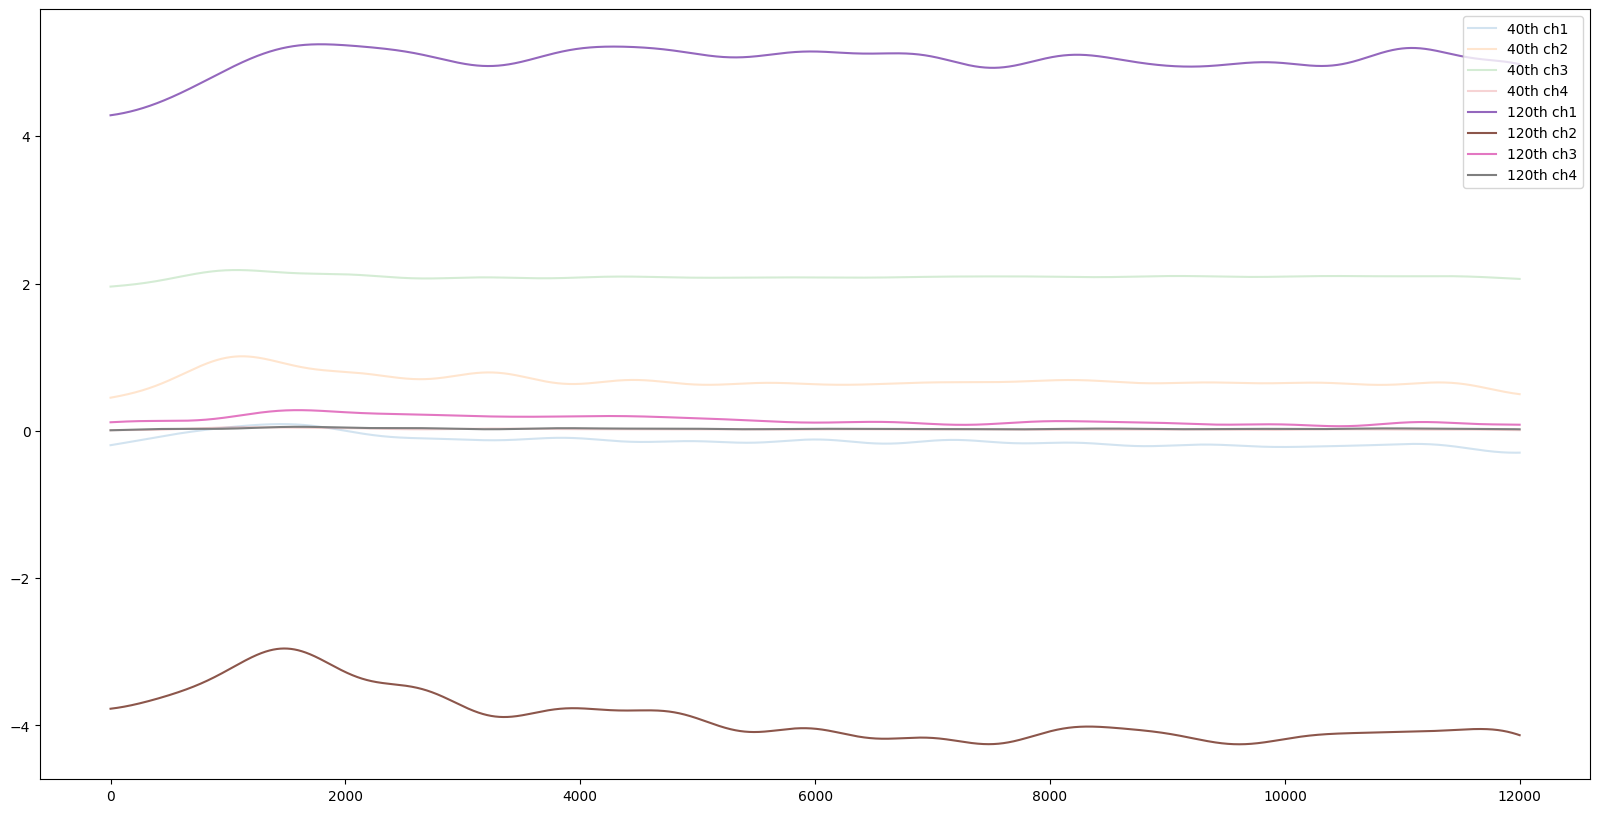

In [58]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(Extension_signal_filtered[40],label=['40th '+s for s in col_names],alpha=0.2)
ax.plot(Extension_signal_filtered[120],label=['120th '+s for s in col_names])

plt.legend()
plt.show()

The signals of each channel show very similar shapes but different locations(y-axis)

In [57]:
# tasks to do :
# 1. find the best classifier for the same pattern but different range of values
# 2. classify the data with varying time ranges ('Down-Scaling', 'Up-Scaling')
# 3. repeat classifying with different window sizes to get the best

In [4]:
"""
for i in range(40): #data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for f in col_names: #ch1 to ch4
        
        for j in range(5): #pattern1 to pattern5
            
            for g in range(10): #gesture1 to gesture10
                if g == 0: #make a dataframe what sets the standard index
                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]) #new dataframe to set columns as gestures

                else: #appending the other features by pd.concat
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.concat([globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)],pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]).set_index(globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].index)],axis=1,join='inner')
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index

                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)] = globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].iloc[3000:17000] #new dataframe with a little of the rest time(0:4000, 16000:20000)
                    globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index
            
            globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
            globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
"""

"\nfor i in range(40): #data1 to data40\n    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)\n\n    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time\n\n    for f in col_names: #ch1 to ch4\n        \n        for j in range(5): #pattern1 to pattern5\n            \n            for g in range(10): #gesture1 to gesture10\n                if g == 0: #make a dataframe what sets the standard index\n                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures\n                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFr

In [10]:
"""
#Remove 'Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers' (no remarkable signal characteristic between two similar)
for i in range(40):
    for j in range(4):
        for k in range(5):
            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)
"""

"\nfor i in range(40):\n    for j in range(4):\n        for k in range(5):\n            globals()['data{}_ch{}_gestures{}_litre'.format(i+1,j+1,k+1)].drop(columns=['Ulnar Deviation', 'Radial Deviation', 'Abduction of Fingers', 'Adduction of Fingers'], inplace=True)\n"